# Channel Head Coupling & Lengthwise Asymmetry Analysis - All 18 Basins

This notebook performs full analysis of coupled channel heads for **all 18 basins** from Goren & Shelef (2024):

- **Coupling Analysis**: Detecting spatially touching channel head basins
- **Lengthwise Asymmetry (ΔL)**: Measuring flow path length differences

## Basins Analyzed (from Table A1):

| Basin | Location | z_th (m) |
|-------|----------|----------|
| Central Mountain Range | Taiwan | 80 |
| Clan Alpine Mountains | Nevada, USA | 1700 |
| Daquing Shan | China | 1200 |
| Finisterre Range | Papua New Guinea | 400 |
| Humboldt Range | Nevada, USA | 1450 |
| Inyo Mountains | California, USA | 1200 |
| Kammanassie Mountains | South Africa | 630 |
| Lüliang Mountains | China | 1100 |
| Panamint Range | California, USA | 800 |
| Sakhalin Mountains | Russia | 60 |
| Sierra del Valle Fértil | Argentina | 1050 |
| Sierra Madre del Sur | Mexico | 380 |
| Sierra Nevada | Spain | 1200 |
| Sierra Pie de Palo | Argentina | 650 |
| Toano Range | Nevada, USA | 1710 |
| Troodos Mountains | Cyprus | 200 |
| Tsugaru Peninsula | Japan | 30 |
| Yoro Mountains | Japan | 130 |

## 1. Setup and Imports

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import topotoolbox as tt3

# Add project root so "channel_heads" package is visible
project_root = pathlib.Path("/Users/guypi/Projects/channel-heads")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Core analysis imports
from channel_heads import (
    CouplingAnalyzer,
    first_meet_pairs_for_outlet,
    outlet_node_ids_from_streampoi,
    # Lengthwise asymmetry
    LengthwiseAsymmetryAnalyzer,
    compute_asymmetry_statistics,
    merge_coupling_and_asymmetry,
    # Basin configuration
    get_z_th,
    get_basin_config,
    get_reference_delta_L,
    BASIN_CONFIG,
)

# Plotting utilities
from channel_heads.plotting_utils import (
    plot_coupled_pair,
    plot_outlet_view,
    plot_all_coupled_pairs_for_outlet,
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
%matplotlib inline

print("Setup complete!")

Setup complete!


## 2. Basin Configuration

Load basin parameters from Goren & Shelef (2024) Table A1. All 18 basins are configured with their respective DEM paths and paper names.

In [2]:
# Define basins to analyze with their DEM paths
DATA_DIR = pathlib.Path("/Users/guypi/Projects/channel-heads/data/cropped_DEMs")
OUTPUT_DIR = pathlib.Path("/Users/guypi/Projects/channel-heads/data/outputs")

# All 18 basins from Goren & Shelef (2024)
BASINS_TO_ANALYZE = {
    # Original 7 basins
    "inyo": {
        "dem_path": DATA_DIR / "Inyo_strm_crop.tif",
        "paper_name": "inyo",
    },
    "humboldt": {
        "dem_path": DATA_DIR / "Humboldt_strm_crop.tif",
        "paper_name": "humboldt",
    },
    "calnalpine": {
        "dem_path": DATA_DIR / "CalnAlpine_strm_crop.tif",
        "paper_name": "clanalpine",
    },
    "daqing": {
        "dem_path": DATA_DIR / "Daqing_strm_crop.tif",
        "paper_name": "daqing",
    },
    "kammanasie": {
        "dem_path": DATA_DIR / "Kammanasie_strm_crop.tif",
        "paper_name": "kammanassie",
    },
    "luliang": {
        "dem_path": DATA_DIR / "Luliang_strm_crop.tif",
        "paper_name": "luliang",
    },
    "finisterre": {
        "dem_path": DATA_DIR / "Finisterre_strm_crop.tif",
        "paper_name": "finisterre",
    },
    # Additional 11 basins
    "taiwan": {
        "dem_path": DATA_DIR / "Taiwan_strm_crop.tif",
        "paper_name": "taiwan",
    },
    "panamint": {
        "dem_path": DATA_DIR / "Panamint_strm_crop.tif",
        "paper_name": "panamint",
    },
    "sakhalin": {
        "dem_path": DATA_DIR / "Sakhalin_strm_crop.tif",
        "paper_name": "sakhalin",
    },
    "vallefertil": {
        "dem_path": DATA_DIR / "SierradelValleFertil_strm_crop.tif",
        "paper_name": "vallefertil",
    },
    "sierramadre": {
        "dem_path": DATA_DIR / "SierraMadre_strm_crop.tif",
        "paper_name": "sierramadre",
    },
    "sierranevadaspain": {
        "dem_path": DATA_DIR / "SierraNevadaSpain_strm_crop.tif",
        "paper_name": "sierranevada_spain",
    },
    "piedepalo": {
        "dem_path": DATA_DIR / "PieDePalo_strm_crop.tif",
        "paper_name": "piedepalo",
    },
    "toano": {
        "dem_path": DATA_DIR / "Toano_strm_crop.tif",
        "paper_name": "toano",
    },
    "troodos": {
        "dem_path": DATA_DIR / "Troodos_strm_crop.tif",
        "paper_name": "troodos",
    },
    "tsugaru": {
        "dem_path": DATA_DIR / "Tsugaru_strm_crop.tif",
        "paper_name": "tsugaru",
    },
    "yoro": {
        "dem_path": DATA_DIR / "Yoro_strm_crop.tif",
        "paper_name": "yoro",
    },
}

# Stream extraction threshold (default: 145)
STREAM_THRESHOLD = 145

# Show basin configurations
print("=" * 80)
print("Basin Configuration from Goren & Shelef (2024)")
print(f"Total basins: {len(BASINS_TO_ANALYZE)}")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print("=" * 80)

for name, config in BASINS_TO_ANALYZE.items():
    basin_config = get_basin_config(config["paper_name"])
    ref_delta_L = get_reference_delta_L(config["paper_name"])
    dem_exists = config['dem_path'].exists()
    status = "OK" if dem_exists else "MISSING"
    print(f"\n{basin_config['full_name']} [{status}]")
    print(f"  z_th: {basin_config['z_th']} m")
    print(f"  z_max: {basin_config['z_max']} m")
    print(f"  lat: {basin_config['lat']}")
    print(f"  theta (concavity): {basin_config['theta']:.2f}")
    print(f"  Reference delta_L: {ref_delta_L['median']:.2f} ({ref_delta_L['p25']:.2f} - {ref_delta_L['p75']:.2f})")

Basin Configuration from Goren & Shelef (2024)
Total basins: 18
Stream threshold: 145

Inyo Mountains, California [OK]
  z_th: 1200 m
  z_max: 3363 m
  lat: 36.71
  theta (concavity): 0.35
  Reference delta_L: 0.17 (0.08 - 0.34)

Humboldt Range, Nevada [OK]
  z_th: 1450 m
  z_max: 2984 m
  lat: 40.52
  theta (concavity): 0.46
  Reference delta_L: 0.34 (0.13 - 0.61)

Clan Alpine Mountains, Nevada [OK]
  z_th: 1700 m
  z_max: 2677 m
  lat: 39.69
  theta (concavity): 0.34
  Reference delta_L: 0.27 (0.12 - 0.48)

Daquing Shan, China [OK]
  z_th: 1200 m
  z_max: 2293 m
  lat: 40.71
  theta (concavity): 0.55
  Reference delta_L: 0.82 (0.40 - 1.21)

Kammanassie Mountains, South Africa [OK]
  z_th: 630 m
  z_max: 1935 m
  lat: -33.62
  theta (concavity): 0.39
  Reference delta_L: 0.35 (0.17 - 0.62)

Lüliang Mountains, China [OK]
  z_th: 1100 m
  z_max: 2391 m
  lat: 39.27
  theta (concavity): 0.37
  Reference delta_L: 0.46 (0.21 - 0.77)

Finisterre Range, Papua New Guinea [OK]
  z_th: 400 m
  

## 3. Analysis Functions

In [3]:
def load_and_prepare_basin(basin_name, dem_path, z_th, stream_threshold=250):
    """
    Load DEM, apply z_th mask, and create stream network.
    
    Parameters
    ----------
    basin_name : str
        Name of the basin for logging.
    dem_path : Path
        Path to the DEM GeoTIFF file.
    z_th : int
        Elevation threshold for masking (from paper Table A1).
    stream_threshold : int
        Drainage area threshold for stream extraction (default: 145).
    
    Returns
    -------
    dict : Dictionary with dem, fd, s keys.
    """
    print(f"Loading {basin_name}...")
    
    # Load DEM
    dem = tt3.read_tif(str(dem_path))
    print(f"  DEM shape: {dem.z.shape}")
    print(f"  Elevation range: {np.nanmin(dem.z):.0f} - {np.nanmax(dem.z):.0f} m")
    
    # Apply z_th mask (mask elevations below threshold)
    dem.z[dem.z < z_th] = np.nan
    valid_pct = 100 * np.sum(~np.isnan(dem.z)) / dem.z.size
    print(f"  Applied z_th={z_th} m mask: {valid_pct:.1f}% valid pixels")
    
    # Create flow and stream objects
    fd = tt3.FlowObject(dem)
    s = tt3.StreamObject(fd, threshold=stream_threshold)
    
    # Count network features
    n_outlets = np.sum(s.streampoi('outlets'))
    n_heads = np.sum(s.streampoi('channelheads'))
    n_confluences = np.sum(s.streampoi('confluences'))
    print(f"  Stream network (threshold={stream_threshold}):")
    print(f"    Outlets: {n_outlets}, Heads: {n_heads}, Confluences: {n_confluences}")
    
    return {"dem": dem, "fd": fd, "s": s}


def run_full_analysis(s, fd, dem, lat, outlets=None, max_outlets=None):
    """
    Run coupling + lengthwise asymmetry analysis for all outlets.
    
    Parameters
    ----------
    s : StreamObject
        TopoToolbox StreamObject with stream network topology.
    fd : FlowObject
        TopoToolbox FlowObject with flow directions.
    dem : GridObject
        Digital elevation model.
    lat : float
        Latitude of the study area in degrees. Used to convert
        pixel distances to meters for proper L values.
    outlets : list, optional
        List of outlet node IDs. If None, all outlets are used.
    max_outlets : int, optional
        Maximum number of outlets to process.
    
    Returns
    -------
    pd.DataFrame : Combined results with coupling and asymmetry metrics.
    """
    if outlets is None:
        outlets = outlet_node_ids_from_streampoi(s)
    outlets = [int(o) for o in outlets]
    
    if max_outlets and len(outlets) > max_outlets:
        print(f"  Limiting to first {max_outlets} outlets (of {len(outlets)})")
        outlets = outlets[:max_outlets]
    
    # Create analyzers
    coupling_an = CouplingAnalyzer(fd, s, dem, connectivity=8)
    # Pass latitude to get proper meter conversion for L values
    asymmetry_an = LengthwiseAsymmetryAnalyzer(s, dem, lat=lat)
    
    coupling_dfs = []
    asymmetry_dfs = []
    
    for idx, outlet in enumerate(outlets, 1):
        print(f"  [{idx}/{len(outlets)}] outlet={outlet}", end="", flush=True)
        
        # Get first-meet pairs
        pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, outlet)
        
        if not pairs_at_confluence:
            print(" (no pairs)")
            continue
        
        # Coupling analysis - clear cache between outlets to manage memory
        coupling_an.clear_cache()
        df_coupling = coupling_an.evaluate_pairs_for_outlet(outlet, pairs_at_confluence)
        
        # Asymmetry analysis
        asymmetry_an.clear_cache()
        df_asymmetry = asymmetry_an.evaluate_pairs_for_outlet(outlet, pairs_at_confluence)
        
        n_pairs = len(df_coupling)
        n_touching = df_coupling['touching'].sum() if not df_coupling.empty else 0
        print(f" ({n_pairs} pairs, {n_touching} touching)")
        
        if not df_coupling.empty:
            coupling_dfs.append(df_coupling)
        if not df_asymmetry.empty:
            asymmetry_dfs.append(df_asymmetry)
    
    # Combine results
    if not coupling_dfs:
        return pd.DataFrame()
    
    df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)
    df_asymmetry_all = pd.concat(asymmetry_dfs, ignore_index=True)
    
    # Merge coupling and asymmetry results
    df_combined = merge_coupling_and_asymmetry(df_coupling_all, df_asymmetry_all)
    df_combined.sort_values(["outlet", "confluence", "head_1", "head_2"], inplace=True, ignore_index=True)
    
    return df_combined

## 4. Run Analysis for All 18 Basins

In [4]:
# Store results for each basin
basin_results = {}
basin_data = {}

# Check which basins already have results
def get_completed_basins():
    """Return set of basin names that already have output files."""
    completed = set()
    for basin_name in BASINS_TO_ANALYZE.keys():
        output_path = OUTPUT_DIR / basin_name / "coupling_asymmetry_results.csv"
        if output_path.exists():
            completed.add(basin_name)
    return completed

completed_basins = get_completed_basins()
print(f"Already completed: {len(completed_basins)} basins")
print(f"  {', '.join(sorted(completed_basins))}")
print(f"\nRemaining: {len(BASINS_TO_ANALYZE) - len(completed_basins)} basins")
remaining = [b for b in BASINS_TO_ANALYZE.keys() if b not in completed_basins]
print(f"  {', '.join(remaining)}")

# Load existing results for completed basins
for basin_name in completed_basins:
    output_path = OUTPUT_DIR / basin_name / "coupling_asymmetry_results.csv"
    basin_results[basin_name] = pd.read_csv(output_path)
    print(f"  Loaded existing results for {basin_name}: {len(basin_results[basin_name])} pairs")

print("\n" + "=" * 80)

for basin_name, config in BASINS_TO_ANALYZE.items():
    # Skip if already completed
    if basin_name in completed_basins:
        print(f"\nSkipping {basin_name}: already completed")
        continue
    
    # Skip if DEM doesn't exist
    if not config["dem_path"].exists():
        print(f"\nSkipping {basin_name}: DEM not found at {config['dem_path']}")
        continue
    
    print("\n" + "=" * 80)
    print(f"Processing: {basin_name.upper()}")
    print("=" * 80)
    
    # Get basin configuration from paper (includes z_th and lat)
    basin_config = get_basin_config(config["paper_name"])
    z_th = basin_config["z_th"]
    lat = basin_config["lat"]
    
    print(f"  Using z_th={z_th} m, lat={lat}")
    
    # Load and prepare basin
    data = load_and_prepare_basin(
        basin_name=basin_name,
        dem_path=config["dem_path"],
        z_th=z_th,
        stream_threshold=STREAM_THRESHOLD,
    )
    basin_data[basin_name] = data
    
    # Run analysis with latitude for proper meter conversion
    print(f"\nRunning coupling + asymmetry analysis...")
    df_results = run_full_analysis(
        s=data["s"],
        fd=data["fd"],
        dem=data["dem"],
        lat=lat,  # Pass latitude for proper L values in meters
    )
    basin_results[basin_name] = df_results
    
    # Save results
    output_dir = OUTPUT_DIR / basin_name
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / "coupling_asymmetry_results.csv"
    df_results.to_csv(output_path, index=False)
    print(f"\nSaved results to: {output_path}")

print("\n" + "=" * 80)
print(f"All basins processed! ({len(basin_results)} basins)")
print("=" * 80)

Already completed: 16 basins
  calnalpine, daqing, finisterre, humboldt, inyo, kammanasie, luliang, panamint, sakhalin, sierramadre, sierranevadaspain, taiwan, toano, troodos, tsugaru, yoro

Remaining: 2 basins
  vallefertil, piedepalo
  Loaded existing results for luliang: 1098 pairs
  Loaded existing results for inyo: 119 pairs
  Loaded existing results for panamint: 1348 pairs
  Loaded existing results for calnalpine: 70 pairs
  Loaded existing results for taiwan: 476153 pairs
  Loaded existing results for troodos: 2587 pairs
  Loaded existing results for sierranevadaspain: 724 pairs
  Loaded existing results for kammanasie: 226 pairs
  Loaded existing results for humboldt: 148 pairs
  Loaded existing results for daqing: 115 pairs
  Loaded existing results for sakhalin: 1331 pairs
  Loaded existing results for sierramadre: 151311 pairs
  Loaded existing results for toano: 215 pairs
  Loaded existing results for yoro: 24 pairs
  Loaded existing results for finisterre: 77539 pairs
  L

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_91723/2000806867.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


## 5. Results Summary

In [5]:
# Summary table
summary_rows = []

for basin_name, df in basin_results.items():
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    # Compute statistics
    n_pairs = len(df)
    n_touching = df['touching'].sum()
    touch_pct = 100 * n_touching / n_pairs if n_pairs > 0 else 0
    
    # delta_L statistics
    delta_L_stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    summary_rows.append({
        "Basin": config["full_name"],
        "z_th (m)": config["z_th"],
        "Total Pairs": n_pairs,
        "Touching Pairs": n_touching,
        "Touch %": f"{touch_pct:.1f}%",
        "delta_L median": f"{delta_L_stats['median']:.3f}",
        "delta_L (25-75%)": f"({delta_L_stats['p25']:.2f} - {delta_L_stats['p75']:.2f})",
        "Ref delta_L": f"{ref['median']:.2f} ({ref['p25']:.2f} - {ref['p75']:.2f})",
    })

df_summary = pd.DataFrame(summary_rows)
print("\n=== Analysis Summary - All 18 Basins ===")
print(df_summary.to_string(index=False))


=== Analysis Summary - All 18 Basins ===
                              Basin  z_th (m)  Total Pairs  Touching Pairs Touch % delta_L median delta_L (25-75%)        Ref delta_L
           Lüliang Mountains, China      1100         1098             120   10.9%          1.045    (0.61 - 1.43) 0.46 (0.21 - 0.77)
         Inyo Mountains, California      1200          119              28   23.5%          0.851    (0.56 - 1.33) 0.17 (0.08 - 0.34)
         Panamint Range, California       800         1348              83    6.2%          0.932    (0.44 - 1.46) 0.40 (0.13 - 0.80)
      Clan Alpine Mountains, Nevada      1700           70              24   34.3%          0.694    (0.42 - 1.07) 0.27 (0.12 - 0.48)
     Central Mountain Range, Taiwan        80       476153            3370    0.7%          1.036    (0.53 - 1.56) 1.16 (0.60 - 1.58)
          Troodos Mountains, Cyprus       200         2587             175    6.8%          0.933    (0.45 - 1.44) 0.84 (0.42 - 1.26)
               Sierr

In [6]:
# Show sample results for each basin
for basin_name, df in basin_results.items():
    if df.empty:
        continue
    
    print(f"\n=== {basin_name.upper()} - Sample Results ===")
    print(f"Columns: {list(df.columns)}")
    print()
    # Show touching pairs with asymmetry
    df_touching = df[df['touching'] == True].head(5)
    if not df_touching.empty:
        print("Sample touching pairs:")
        print(df_touching[['outlet', 'confluence', 'head_1', 'head_2', 'touching', 
                           'L_1', 'L_2', 'delta_L', 'overlap_px', 'contact_px']].to_string(index=False))
    else:
        print("No touching pairs found.")


=== LULIANG - Sample Results ===
Columns: ['outlet', 'confluence', 'head_1', 'head_2', 'touching', 'overlap_px', 'contact_px', 'size1_px', 'size2_px', 'skipped_prefilter', 'L_1', 'L_2', 'delta_L', 'distance_unit']

Sample touching pairs:
 outlet  confluence  head_1  head_2  touching         L_1         L_2  delta_L  overlap_px  contact_px
     14          85      21     186      True 1374.539163 2179.725650 0.453082           0          20
     75          75      65     116      True  751.761087 1910.202749 0.870366           0          33
    224         214     158     222      True  507.752525  359.035249 0.343146           0          18
    392         399     533     610      True 1144.485881 2844.369430 0.852316           0          36
    392         459     527     610      True 1422.184715 1814.910190 0.242641           0          39

=== INYO - Sample Results ===
Columns: ['outlet', 'confluence', 'head_1', 'head_2', 'touching', 'overlap_px', 'contact_px', 'size1_px', 'size2

## 6. Lengthwise Asymmetry (delta_L) Distribution

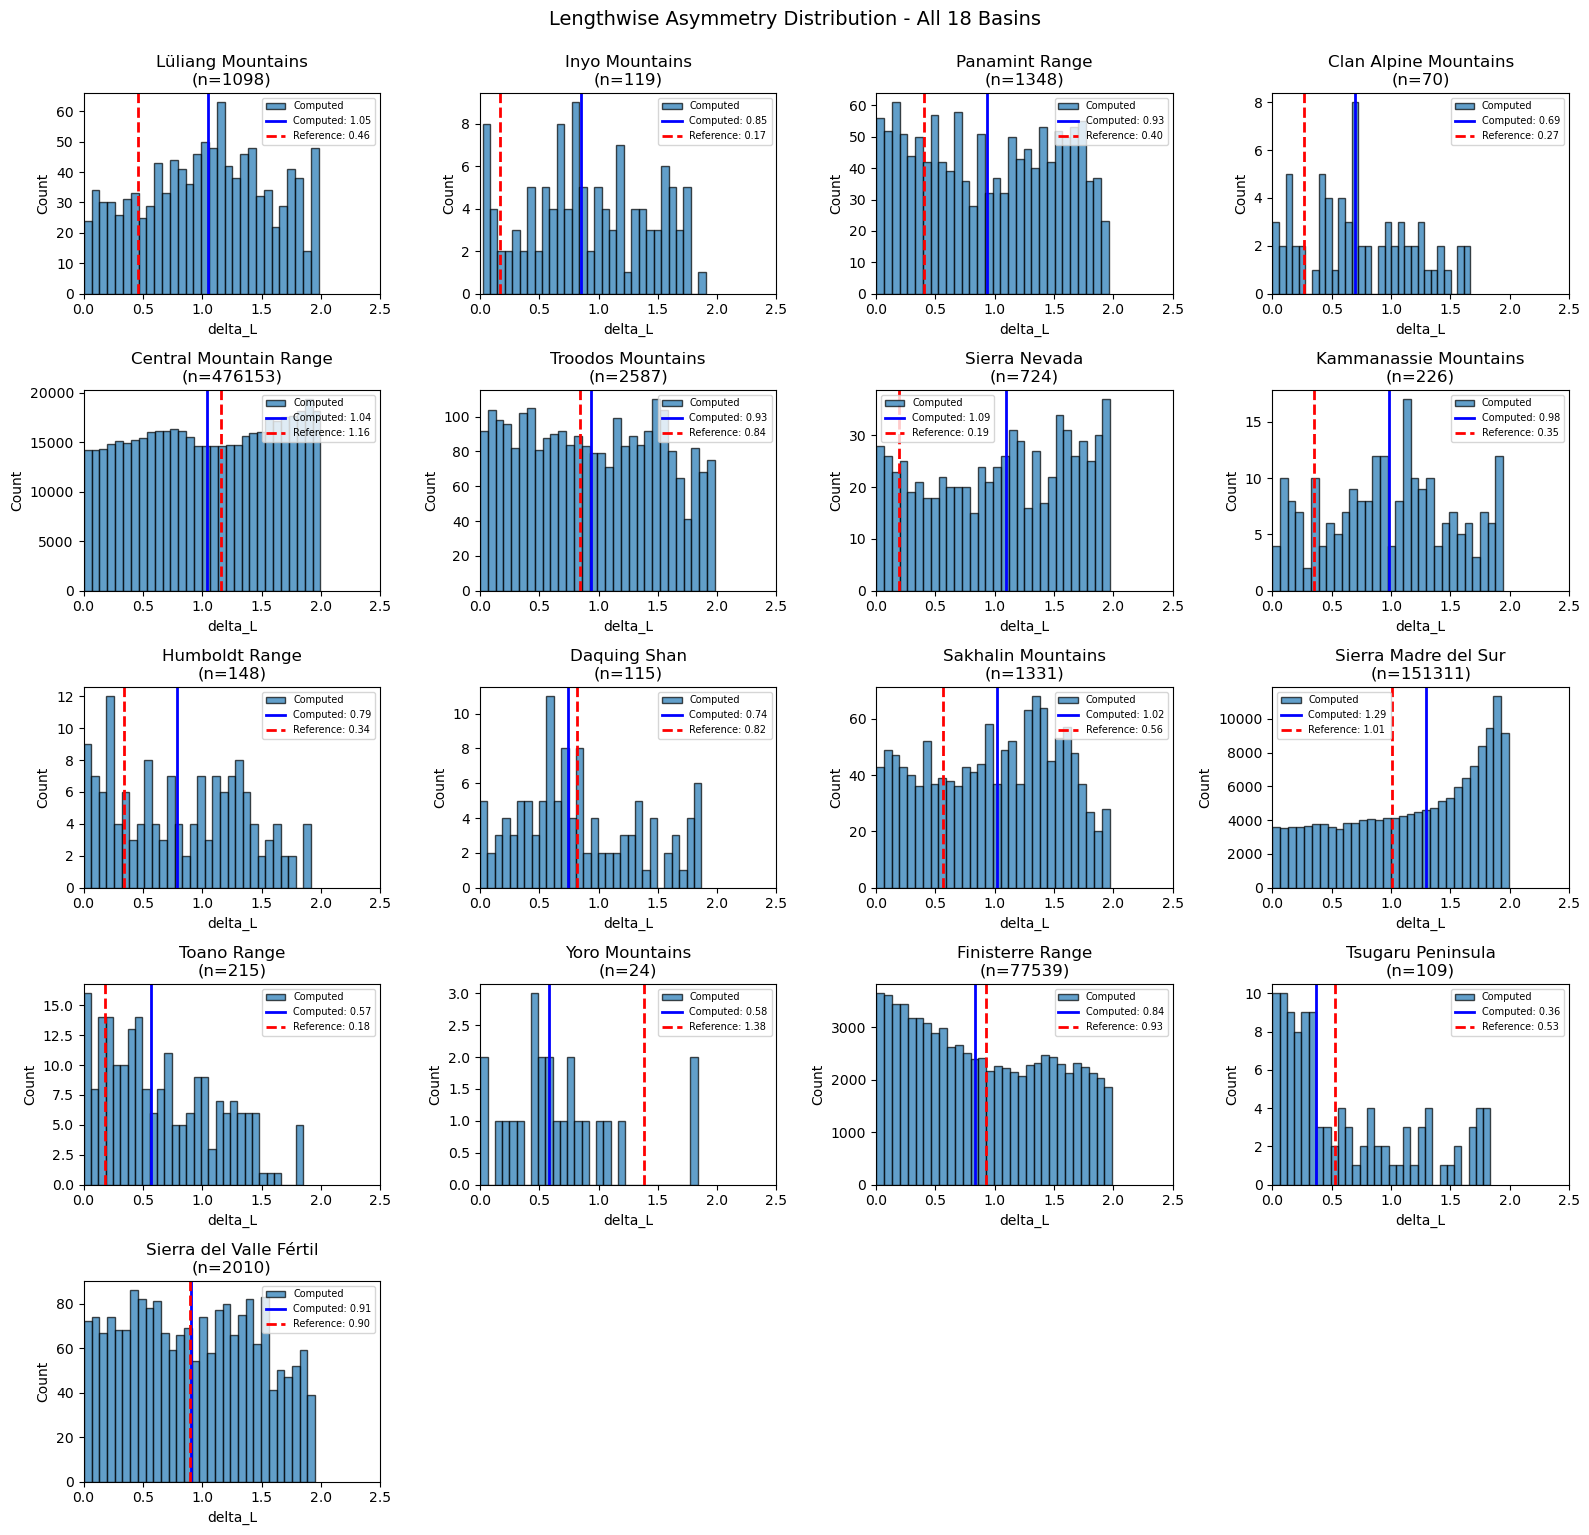

In [7]:
# Plot delta_L distribution for all basins
n_basins = len(basin_results)
n_cols = 4
n_rows = (n_basins + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = np.atleast_1d(axes).flatten()

for idx, (basin_name, df) in enumerate(basin_results.items()):
    ax = axes[idx]
    
    if df.empty:
        ax.set_title(f"{basin_name}: No data")
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    # Get delta_L values
    delta_L = df['delta_L'].dropna()
    stats = compute_asymmetry_statistics(delta_L)
    
    # Plot histogram
    ax.hist(delta_L, bins=30, alpha=0.7, edgecolor='black', label='Computed')
    
    # Add reference lines
    ax.axvline(stats['median'], color='blue', linestyle='-', linewidth=2, 
               label=f'Computed: {stats["median"]:.2f}')
    ax.axvline(ref['median'], color='red', linestyle='--', linewidth=2,
               label=f'Reference: {ref["median"]:.2f}')
    
    ax.set_xlabel('delta_L')
    ax.set_ylabel('Count')
    # Get short name (first part before comma)
    short_name = config["full_name"].split(',')[0]
    ax.set_title(f"{short_name}\n(n={len(delta_L)})")
    ax.legend(fontsize=7)
    ax.set_xlim(0, 2.5)

# Hide unused subplots
for idx in range(len(basin_results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Lengthwise Asymmetry Distribution - All 18 Basins', y=1.02, fontsize=14)
plt.show()

## 7. Comparison with Paper Reference Values

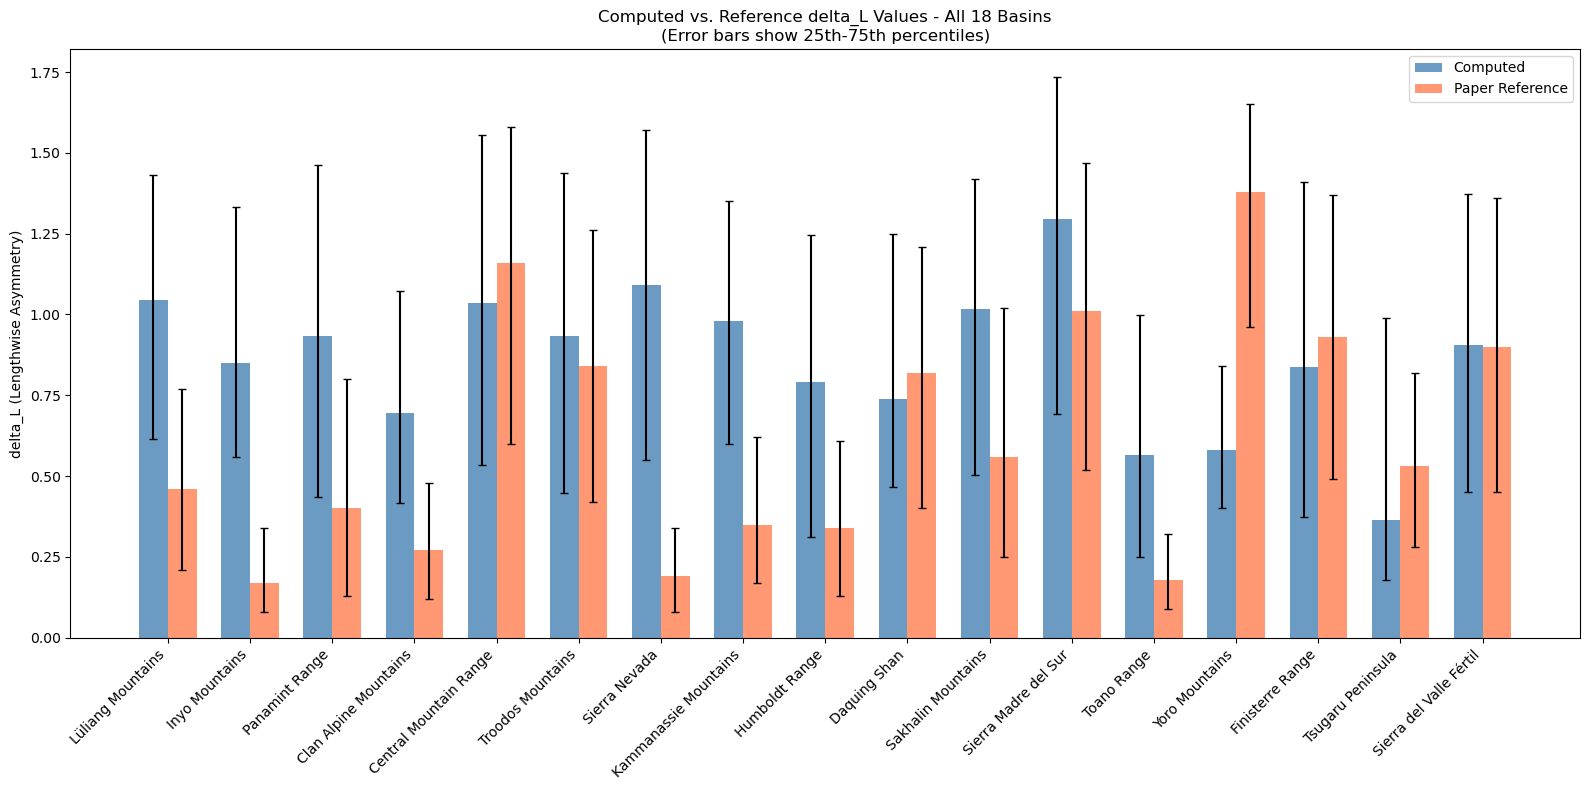


=== Computed vs. Reference delta_L ===
Basin                                    Computed                  Reference                
------------------------------------------------------------------------------------------
Lüliang Mountains, China                 1.05 (0.61-1.43)          0.46 (0.21-0.77)         
Inyo Mountains, California               0.85 (0.56-1.33)          0.17 (0.08-0.34)         
Panamint Range, California               0.93 (0.44-1.46)          0.40 (0.13-0.80)         
Clan Alpine Mountains, Nevada            0.69 (0.42-1.07)          0.27 (0.12-0.48)         
Central Mountain Range, Taiwan           1.04 (0.53-1.56)          1.16 (0.60-1.58)         
Troodos Mountains, Cyprus                0.93 (0.45-1.44)          0.84 (0.42-1.26)         
Sierra Nevada, Spain                     1.09 (0.55-1.57)          0.19 (0.08-0.34)         
Kammanassie Mountains, South Africa      0.98 (0.60-1.35)          0.35 (0.17-0.62)         
Humboldt Range, Nevada          

In [8]:
# Create comparison plot
fig, ax = plt.subplots(figsize=(16, 8))

x_positions = []
computed_medians = []
computed_errors = []
reference_medians = []
reference_errors = []
labels = []

for i, basin_name in enumerate(basin_results.keys()):
    df = basin_results[basin_name]
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    x_positions.append(len(x_positions))
    labels.append(config['full_name'].split(',')[0])  # Short name
    
    computed_medians.append(stats['median'])
    computed_errors.append([[stats['median'] - stats['p25']], [stats['p75'] - stats['median']]])
    
    reference_medians.append(ref['median'])
    reference_errors.append([[ref['median'] - ref['p25']], [ref['p75'] - ref['median']]])

# Plot
x = np.array(x_positions)
width = 0.35

# Computed values
ax.bar(x - width/2, computed_medians, width, label='Computed', color='steelblue', alpha=0.8)
for i, (pos, med, err) in enumerate(zip(x - width/2, computed_medians, computed_errors)):
    ax.errorbar(pos, med, yerr=err, fmt='none', color='black', capsize=3)

# Reference values
ax.bar(x + width/2, reference_medians, width, label='Paper Reference', color='coral', alpha=0.8)
for i, (pos, med, err) in enumerate(zip(x + width/2, reference_medians, reference_errors)):
    ax.errorbar(pos, med, yerr=err, fmt='none', color='black', capsize=3)

ax.set_ylabel('delta_L (Lengthwise Asymmetry)')
ax.set_title('Computed vs. Reference delta_L Values - All 18 Basins\n(Error bars show 25th-75th percentiles)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, None)

plt.tight_layout()
plt.show()

# Print comparison table
print("\n=== Computed vs. Reference delta_L ===")
print(f"{'Basin':<40} {'Computed':<25} {'Reference':<25}")
print("-" * 90)
for basin_name, df in basin_results.items():
    if df.empty:
        continue
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    comp_str = f"{stats['median']:.2f} ({stats['p25']:.2f}-{stats['p75']:.2f})"
    ref_str = f"{ref['median']:.2f} ({ref['p25']:.2f}-{ref['p75']:.2f})"
    print(f"{config['full_name']:<40} {comp_str:<25} {ref_str:<25}")

## 8. Aridity Index vs. Lengthwise Asymmetry

Scatter plot comparing aridity index with lengthwise asymmetry (delta_L) from the paper reference values, with error bars showing the 25th-75th percentile ranges for both variables.

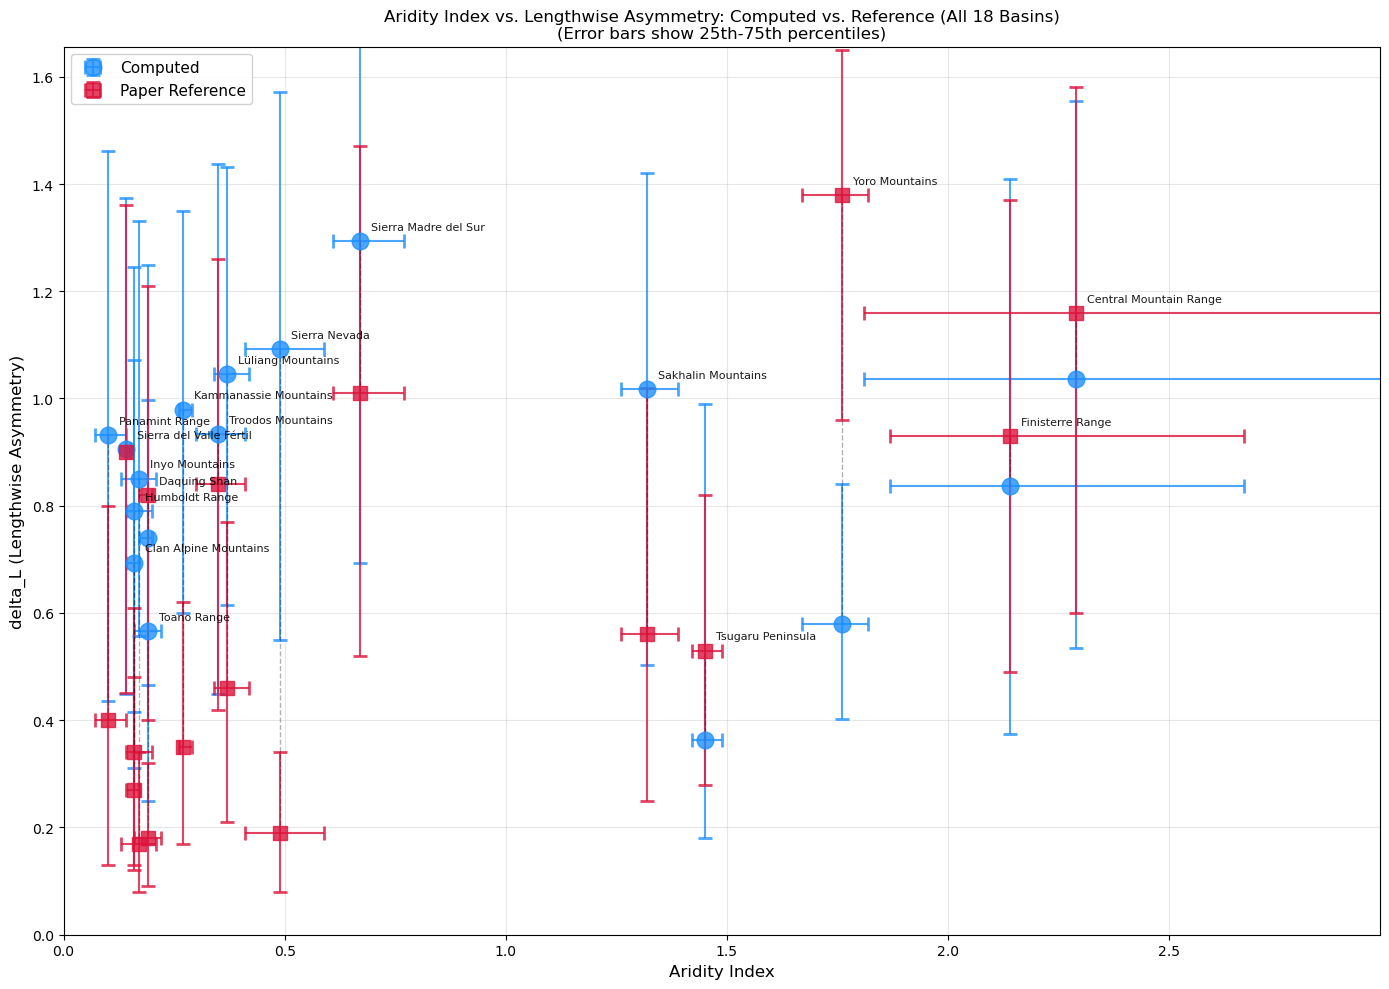


=== Aridity Index vs. delta_L Comparison ===
Basin                               Aridity      Computed delta_L       Reference delta_L     
-------------------------------------------------------------------------------------------
Lüliang Mountains                   0.37         1.05 (0.61-1.43)       0.46 (0.21-0.77)      
Inyo Mountains                      0.17         0.85 (0.56-1.33)       0.17 (0.08-0.34)      
Panamint Range                      0.10         0.93 (0.44-1.46)       0.40 (0.13-0.80)      
Clan Alpine Mountains               0.16         0.69 (0.42-1.07)       0.27 (0.12-0.48)      
Central Mountain Range              2.29         1.04 (0.53-1.56)       1.16 (0.60-1.58)      
Troodos Mountains                   0.35         0.93 (0.45-1.44)       0.84 (0.42-1.26)      
Sierra Nevada                       0.49         1.09 (0.55-1.57)       0.19 (0.08-0.34)      
Kammanassie Mountains               0.27         0.98 (0.60-1.35)       0.35 (0.17-0.62)      
Humbold

In [9]:
# Scatter plot: Aridity Index vs. Lengthwise Asymmetry (delta_L)
# Comparing computed delta_L values with paper reference values

fig, ax = plt.subplots(figsize=(14, 10))

# Collect data for all analyzed basins
basin_names_list = []
aridity_vals = []
aridity_errs_lower = []
aridity_errs_upper = []
computed_delta_L = []
computed_delta_L_errs_lower = []
computed_delta_L_errs_upper = []
reference_delta_L = []
reference_delta_L_errs_lower = []
reference_delta_L_errs_upper = []

for basin_name, df in basin_results.items():
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    # Aridity index from paper
    aridity = config["aridity_index"]
    aridity_25 = config["aridity_index_25"]
    aridity_75 = config["aridity_index_75"]
    
    # Computed Delta L from our analysis
    stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    # Reference Delta L from paper
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    basin_names_list.append(config['full_name'].split(',')[0])
    
    aridity_vals.append(aridity)
    aridity_errs_lower.append(aridity - aridity_25)
    aridity_errs_upper.append(aridity_75 - aridity)
    
    computed_delta_L.append(stats['median'])
    computed_delta_L_errs_lower.append(stats['median'] - stats['p25'])
    computed_delta_L_errs_upper.append(stats['p75'] - stats['median'])
    
    reference_delta_L.append(ref['median'])
    reference_delta_L_errs_lower.append(ref['median'] - ref['p25'])
    reference_delta_L_errs_upper.append(ref['p75'] - ref['median'])

# Plot computed values (blue circles)
for i in range(len(aridity_vals)):
    ax.errorbar(
        aridity_vals[i], computed_delta_L[i],
        xerr=[[aridity_errs_lower[i]], [aridity_errs_upper[i]]],
        yerr=[[computed_delta_L_errs_lower[i]], [computed_delta_L_errs_upper[i]]],
        fmt='o', markersize=12, capsize=5, capthick=2,
        color='dodgerblue', ecolor='dodgerblue', alpha=0.8,
        label='Computed' if i == 0 else None
    )

# Plot reference values (red squares)
for i in range(len(aridity_vals)):
    ax.errorbar(
        aridity_vals[i], reference_delta_L[i],
        xerr=[[aridity_errs_lower[i]], [aridity_errs_upper[i]]],
        yerr=[[reference_delta_L_errs_lower[i]], [reference_delta_L_errs_upper[i]]],
        fmt='s', markersize=10, capsize=5, capthick=2,
        color='crimson', ecolor='crimson', alpha=0.8,
        label='Paper Reference' if i == 0 else None
    )

# Draw lines connecting computed and reference for each basin
for i in range(len(aridity_vals)):
    ax.plot([aridity_vals[i], aridity_vals[i]], 
            [computed_delta_L[i], reference_delta_L[i]], 
            'k--', alpha=0.3, linewidth=1)

# Add labels to computed points
for i, label in enumerate(basin_names_list):
    # Position label above or below based on which point is higher
    if computed_delta_L[i] >= reference_delta_L[i]:
        y_pos = computed_delta_L[i]
        xytext = (8, 8)
    else:
        y_pos = reference_delta_L[i]
        xytext = (8, 8)
    
    ax.annotate(
        label, 
        (aridity_vals[i], y_pos),
        textcoords="offset points",
        xytext=xytext,
        fontsize=8,
        alpha=0.9
    )

ax.set_xlabel('Aridity Index', fontsize=12)
ax.set_ylabel('delta_L (Lengthwise Asymmetry)', fontsize=12)
ax.set_title('Aridity Index vs. Lengthwise Asymmetry: Computed vs. Reference (All 18 Basins)\n(Error bars show 25th-75th percentiles)', fontsize=12)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Set axis limits with some padding
all_delta_L = computed_delta_L + reference_delta_L
ax.set_xlim(0, max(aridity_vals) * 1.3)
ax.set_ylim(0, max(all_delta_L) * 1.2)

plt.tight_layout()
plt.show()

# Print comparison table
print("\n=== Aridity Index vs. delta_L Comparison ===")
print(f"{'Basin':<35} {'Aridity':<12} {'Computed delta_L':<22} {'Reference delta_L':<22}")
print("-" * 91)
for i, basin_name in enumerate(basin_results.keys()):
    if basin_results[basin_name].empty:
        continue
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    stats = compute_asymmetry_statistics(basin_results[basin_name]['delta_L'].dropna())
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    name = config['full_name'].split(',')[0]
    aridity_str = f"{config['aridity_index']:.2f}"
    computed_str = f"{stats['median']:.2f} ({stats['p25']:.2f}-{stats['p75']:.2f})"
    ref_str = f"{ref['median']:.2f} ({ref['p25']:.2f}-{ref['p75']:.2f})"
    print(f"{name:<35} {aridity_str:<12} {computed_str:<22} {ref_str:<22}")

## 9. Concavity (theta) vs. Lengthwise Asymmetry

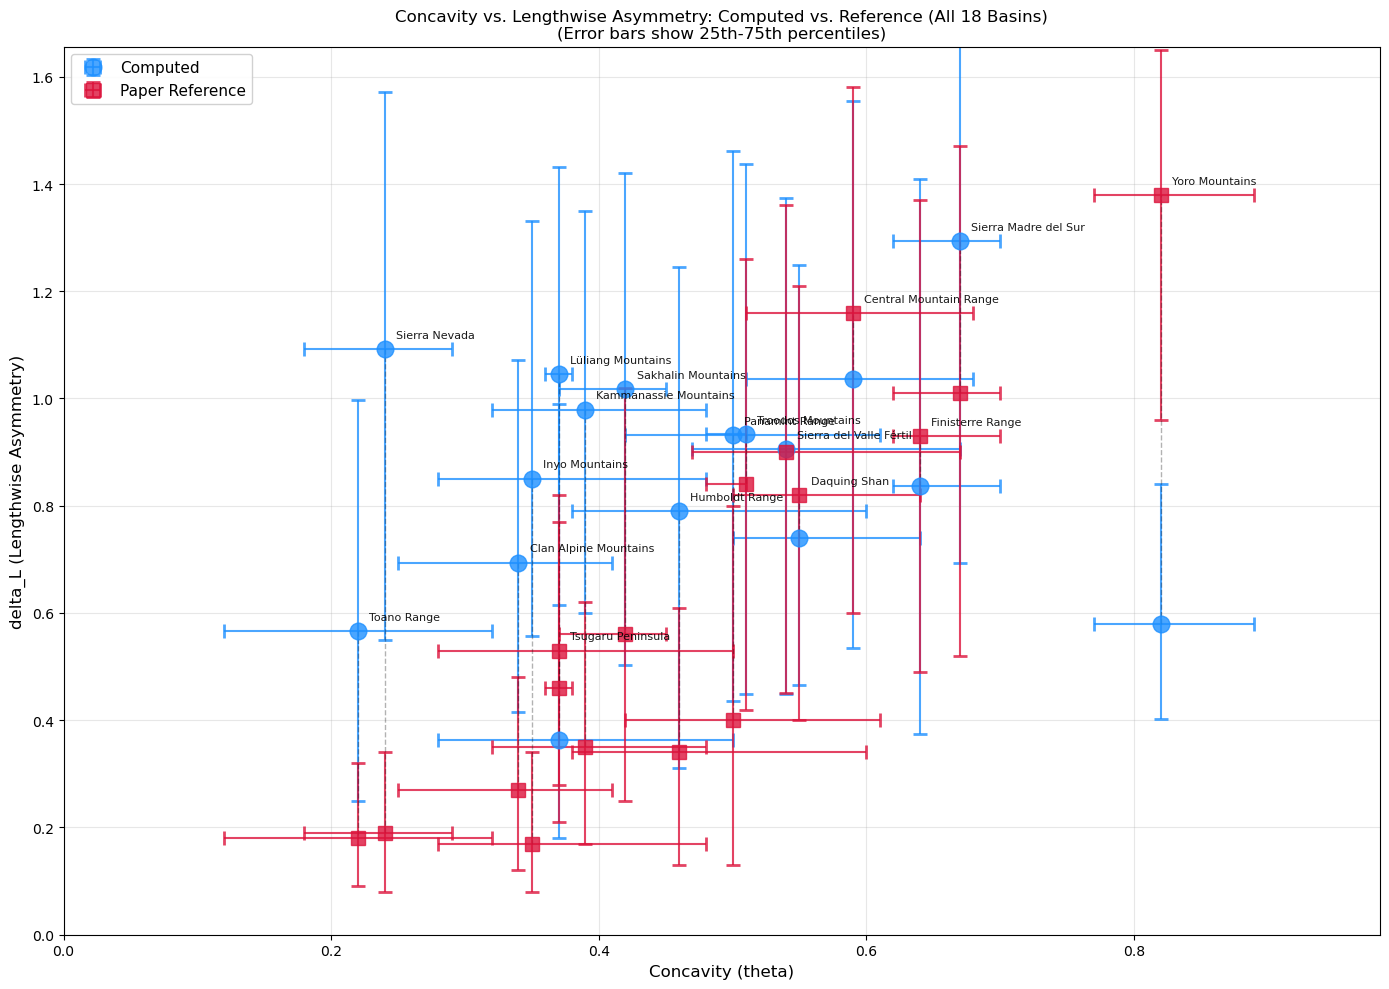

In [10]:
# Scatter plot: Concavity (theta) vs. Lengthwise Asymmetry (delta_L)

fig, ax = plt.subplots(figsize=(14, 10))

# Collect data
theta_vals = []
theta_errs_lower = []
theta_errs_upper = []

for basin_name, df in basin_results.items():
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    theta_vals.append(config["theta"])
    theta_errs_lower.append(config["theta"] - config["theta_25"])
    theta_errs_upper.append(config["theta_75"] - config["theta"])

# Plot computed values (blue circles)
for i in range(len(theta_vals)):
    ax.errorbar(
        theta_vals[i], computed_delta_L[i],
        xerr=[[theta_errs_lower[i]], [theta_errs_upper[i]]],
        yerr=[[computed_delta_L_errs_lower[i]], [computed_delta_L_errs_upper[i]]],
        fmt='o', markersize=12, capsize=5, capthick=2,
        color='dodgerblue', ecolor='dodgerblue', alpha=0.8,
        label='Computed' if i == 0 else None
    )

# Plot reference values (red squares)
for i in range(len(theta_vals)):
    ax.errorbar(
        theta_vals[i], reference_delta_L[i],
        xerr=[[theta_errs_lower[i]], [theta_errs_upper[i]]],
        yerr=[[reference_delta_L_errs_lower[i]], [reference_delta_L_errs_upper[i]]],
        fmt='s', markersize=10, capsize=5, capthick=2,
        color='crimson', ecolor='crimson', alpha=0.8,
        label='Paper Reference' if i == 0 else None
    )

# Draw lines connecting computed and reference for each basin
for i in range(len(theta_vals)):
    ax.plot([theta_vals[i], theta_vals[i]], 
            [computed_delta_L[i], reference_delta_L[i]], 
            'k--', alpha=0.3, linewidth=1)

# Add labels
for i, label in enumerate(basin_names_list):
    if computed_delta_L[i] >= reference_delta_L[i]:
        y_pos = computed_delta_L[i]
        xytext = (8, 8)
    else:
        y_pos = reference_delta_L[i]
        xytext = (8, 8)
    
    ax.annotate(
        label, 
        (theta_vals[i], y_pos),
        textcoords="offset points",
        xytext=xytext,
        fontsize=8,
        alpha=0.9
    )

ax.set_xlabel('Concavity (theta)', fontsize=12)
ax.set_ylabel('delta_L (Lengthwise Asymmetry)', fontsize=12)
ax.set_title('Concavity vs. Lengthwise Asymmetry: Computed vs. Reference (All 18 Basins)\n(Error bars show 25th-75th percentiles)', fontsize=12)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

ax.set_xlim(0, max(theta_vals) * 1.2)
ax.set_ylim(0, max(all_delta_L) * 1.2)

plt.tight_layout()
plt.show()

## 10. Basin Overview Visualizations

Plot basin overviews for selected basins with the most touching pairs.

Showing basin overviews for top 6 basins by touching pair count:
  taiwan: 3370 touching pairs
  sierramadre: 1867 touching pairs
  finisterre: 1365 touching pairs
  troodos: 175 touching pairs
  vallefertil: 132 touching pairs
  luliang: 120 touching pairs
  Loading DEM for taiwan...
Loading taiwan...
  DEM shape: (2118, 1957)
  Elevation range: -28 - 3917 m
  Applied z_th=80 m mask: 60.4% valid pixels
  Stream network (threshold=145):
    Outlets: 426, Heads: 4458, Confluences: 3989

Central Mountain Range, Taiwan - Outlet 8109


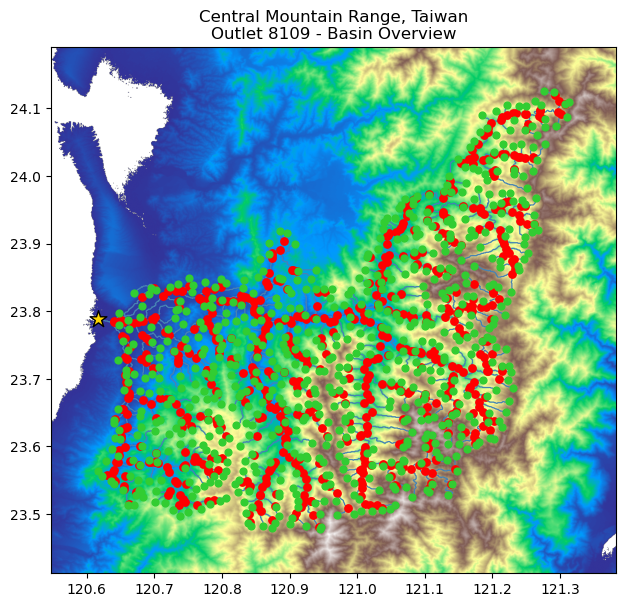

  Loading DEM for sierramadre...
Loading sierramadre...
  DEM shape: (1582, 1551)
  Elevation range: -4 - 3105 m
  Applied z_th=380 m mask: 64.3% valid pixels
  Stream network (threshold=145):
    Outlets: 423, Heads: 2842, Confluences: 2398

Sierra Madre del Sur, Mexico - Outlet 29446


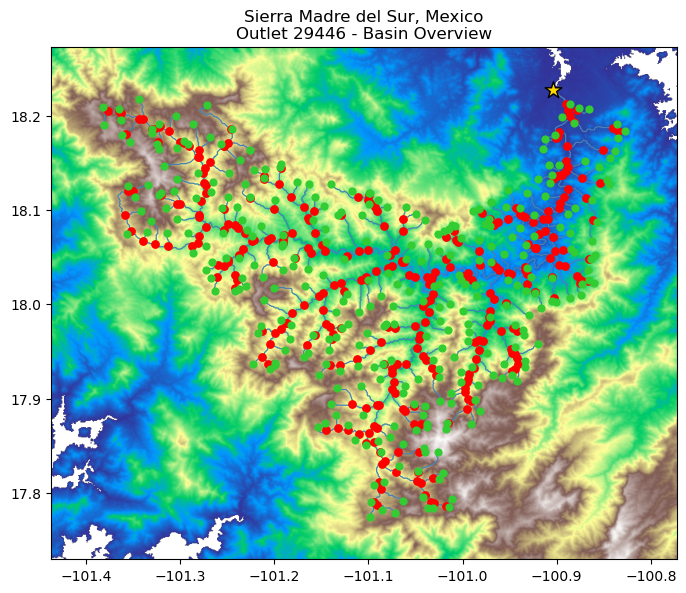

  Loading DEM for finisterre...
Loading finisterre...
  DEM shape: (943, 1674)
  Elevation range: 0 - 4096 m
  Applied z_th=400 m mask: 71.3% valid pixels
  Stream network (threshold=145):
    Outlets: 276, Heads: 2062, Confluences: 1761

Finisterre Range, Papua New Guinea - Outlet 26871


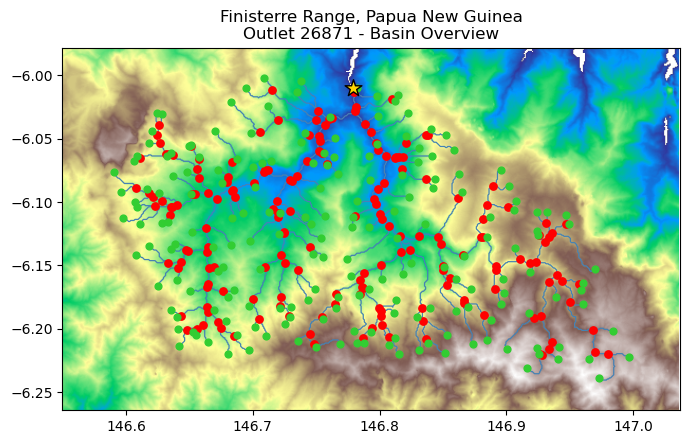

  Loading DEM for troodos...
Loading troodos...
  DEM shape: (278, 660)
  Elevation range: 90 - 1949 m
  Applied z_th=200 m mask: 98.6% valid pixels
  Stream network (threshold=145):
    Outlets: 60, Heads: 339, Confluences: 277

Troodos Mountains, Cyprus - Outlet 1595


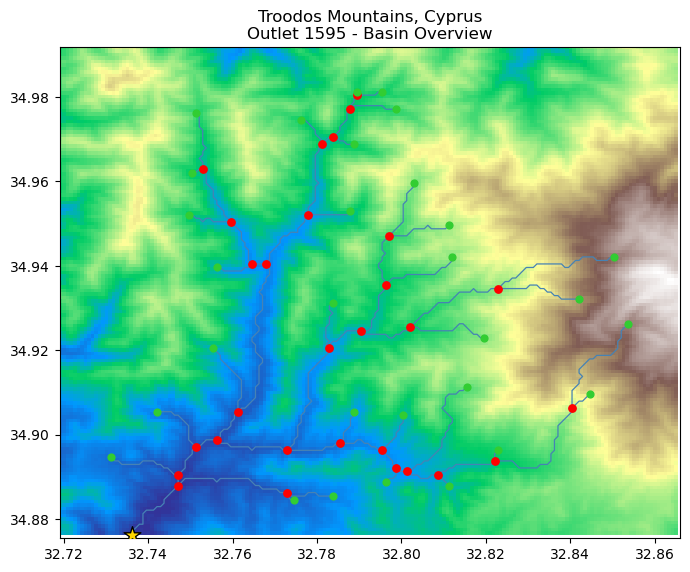


Sierra del Valle Fértil, Argentina - Outlet 7547


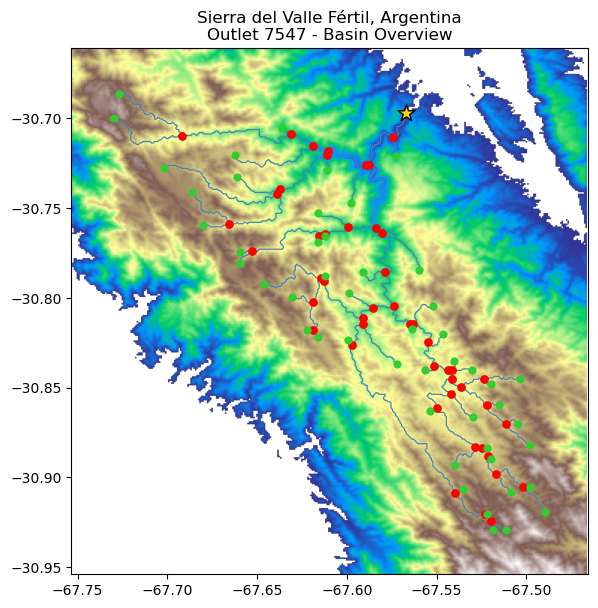

  Loading DEM for luliang...
Loading luliang...
  DEM shape: (349, 756)
  Elevation range: 857 - 2397 m
  Applied z_th=1100 m mask: 55.8% valid pixels
  Stream network (threshold=145):
    Outlets: 113, Heads: 291, Confluences: 177

Lüliang Mountains, China - Outlet 880


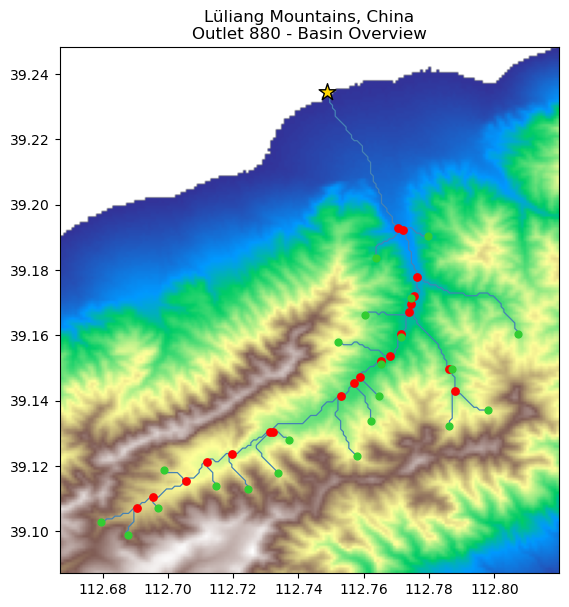

In [11]:
# Plot basin overview for a subset of basins (to avoid too many plots)
# Select basins with most touching pairs
basin_touching_counts = {}
for basin_name, df in basin_results.items():
    if not df.empty:
        basin_touching_counts[basin_name] = df['touching'].sum()

# Sort by touching counts and select top 6
top_basins = sorted(basin_touching_counts.items(), key=lambda x: x[1], reverse=True)[:6]
print(f"Showing basin overviews for top 6 basins by touching pair count:")
for name, count in top_basins:
    print(f"  {name}: {count} touching pairs")

# Helper function to get or load basin data
def get_basin_data(basin_name):
    """Get basin data, loading from DEM if not already in memory."""
    if basin_name in basin_data:
        return basin_data[basin_name]
    
    # Load DEM data for visualization
    config = BASINS_TO_ANALYZE[basin_name]
    if not config["dem_path"].exists():
        print(f"  Warning: DEM not found for {basin_name}")
        return None
    
    print(f"  Loading DEM for {basin_name}...")
    basin_config = get_basin_config(config["paper_name"])
    data = load_and_prepare_basin(
        basin_name=basin_name,
        dem_path=config["dem_path"],
        z_th=basin_config["z_th"],
        stream_threshold=STREAM_THRESHOLD,
    )
    basin_data[basin_name] = data  # Cache for later use
    return data

for basin_name, _ in top_basins:
    data = get_basin_data(basin_name)
    if data is None:
        print(f"\nSkipping {basin_name}: DEM not available")
        continue
    
    df = basin_results[basin_name]
    
    if df.empty:
        continue
    
    # Get the outlet with most touching pairs
    touching_counts = df[df['touching']].groupby('outlet').size()
    if touching_counts.empty:
        pair_counts = df.groupby('outlet').size()
        best_outlet = pair_counts.idxmax()
    else:
        best_outlet = touching_counts.idxmax()
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    print(f"\n{'='*60}")
    print(f"{config['full_name']} - Outlet {best_outlet}")
    print(f"{'='*60}")
    
    # Plot outlet view
    fig, ax = plot_outlet_view(
        s=data["s"],
        outlet_id=best_outlet,
        dem=data["dem"],
        view_mode="crop",
        pad_frac=0.1,
    )
    ax.set_title(f"{config['full_name']}\nOutlet {best_outlet} - Basin Overview")
    plt.show()

## 11. Coupled Channel Head Pairs Visualization


Lüliang Mountains, China - Coupled Pairs
Total touching pairs: 120
Computed ΔL median: 0.554

Closest to median: heads (2213, 2522)
  L_1=3007.0m, L_2=5315.7m, delta_L=0.555
  Contact: 17px


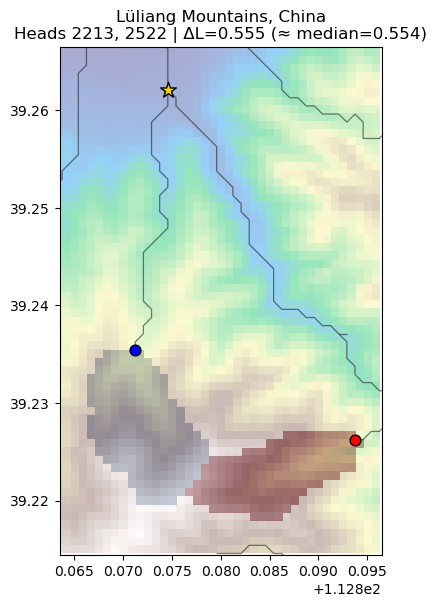


Lüliang Mountains, China - Coupled Pairs
Total touching pairs: 120
Computed ΔL median: 0.554

Closest to median: heads (2213, 2522)
  L_1=3007.0m, L_2=5315.7m, delta_L=0.555
  Contact: 17px


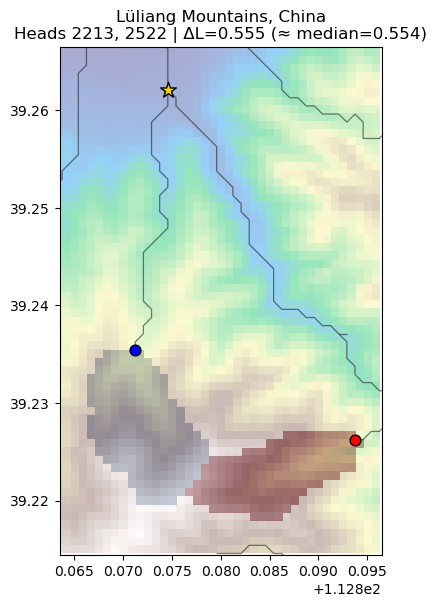


Lüliang Mountains, China - Coupled Pairs
Total touching pairs: 120
Computed ΔL median: 0.554

Closest to median: heads (2213, 2522)
  L_1=3007.0m, L_2=5315.7m, delta_L=0.555
  Contact: 17px


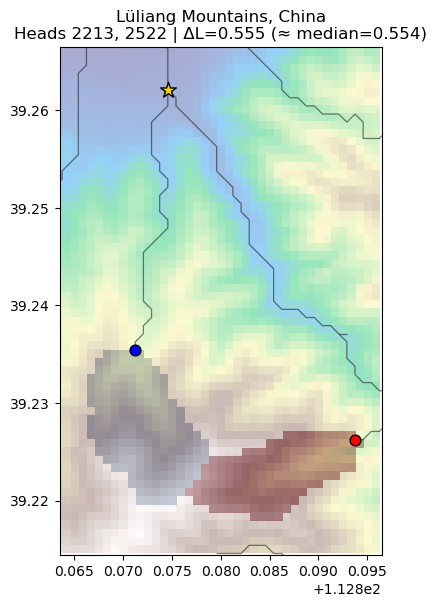


Lüliang Mountains, China - Coupled Pairs
Total touching pairs: 120
Computed ΔL median: 0.554

Closest to median: heads (2213, 2522)
  L_1=3007.0m, L_2=5315.7m, delta_L=0.555
  Contact: 17px


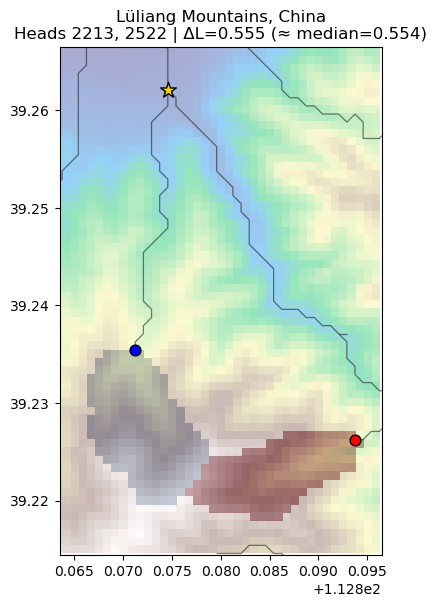


Lüliang Mountains, China - Coupled Pairs
Total touching pairs: 120
Computed ΔL median: 0.554

Closest to median: heads (2213, 2522)
  L_1=3007.0m, L_2=5315.7m, delta_L=0.555
  Contact: 17px


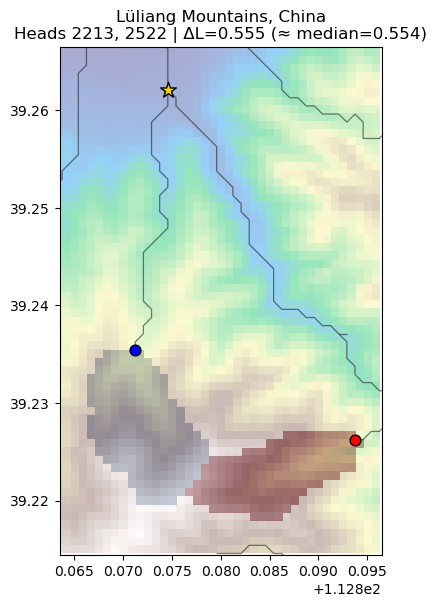


Lüliang Mountains, China - Coupled Pairs
Total touching pairs: 120
Computed ΔL median: 0.554

Closest to median: heads (2213, 2522)
  L_1=3007.0m, L_2=5315.7m, delta_L=0.555
  Contact: 17px


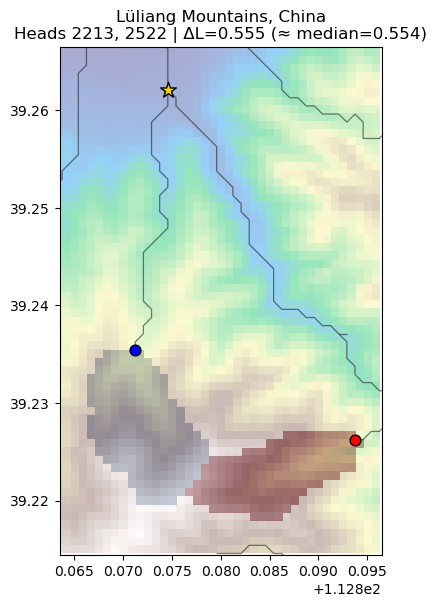


Lüliang Mountains, China - Coupled Pairs
Total touching pairs: 120
Computed ΔL median: 0.554

Closest to median: heads (2213, 2522)
  L_1=3007.0m, L_2=5315.7m, delta_L=0.555
  Contact: 17px


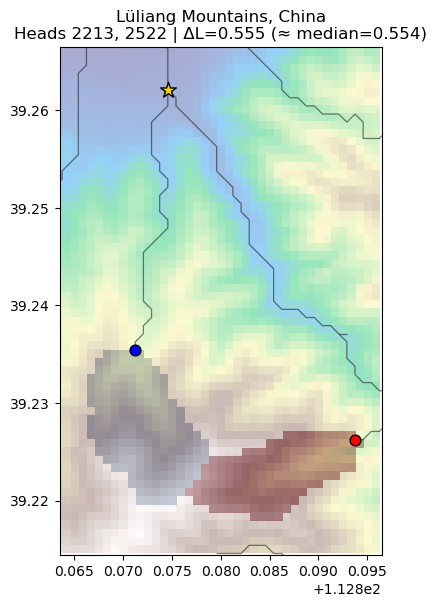

In [17]:
# Plot coupled pairs closest to computed median delta_L for top basins
for _ in basin_name[:]:  # Limit to top 3
    data = get_basin_data(basin_name)
    if data is None:
        print(f"\nSkipping {basin_name}: DEM not available")
        continue
    
    df = basin_results[basin_name]
    
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    # Get touching pairs
    df_touching = df[df['touching'] == True].copy()
    
    if df_touching.empty:
        print(f"\nNo touching pairs for {basin_name}")
        continue
    
    # Compute median from our own delta_L values
    computed_median = df_touching['delta_L'].median()
    
    print(f"\n{'='*60}")
    print(f"{config['full_name']} - Coupled Pairs")
    print(f"Total touching pairs: {len(df_touching)}")
    print(f"Computed ΔL median: {computed_median:.3f}")
    print(f"{'='*60}")
    
    # Find pair closest to the computed median
    df_touching['dist_to_median'] = (df_touching['delta_L'] - computed_median).abs()
    closest_idx = df_touching['dist_to_median'].idxmin()
    row = df_touching.loc[closest_idx]
    
    print(f"\nClosest to median: heads ({row.head_1}, {row.head_2})")
    print(f"  L_1={row.L_1:.1f}m, L_2={row.L_2:.1f}m, delta_L={row.delta_L:.3f}")
    print(f"  Contact: {row.contact_px}px")
    
    try:
        fig, ax = plot_coupled_pair(
            fd=data["fd"],
            s=data["s"],
            dem=data["dem"],
            confluence_id=int(row.confluence),
            head_i=int(row.head_1),
            head_j=int(row.head_2),
            view_mode="crop",
            pad_frac=0.1,
            focus="masks",
        )
        ax.set_title(f"{config['full_name']}\nHeads {row.head_1}, {row.head_2} | ΔL={row.delta_L:.3f} (≈ median={computed_median:.3f})")
        plt.show()
    except Exception as e:
        print(f"  Error plotting: {e}")


## 12. Export Combined Results

In [13]:
# Combine all results into a single DataFrame
all_results = []
for basin_name, df in basin_results.items():
    if df.empty:
        continue
    df_copy = df.copy()
    df_copy['basin'] = basin_name
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    df_copy['basin_full_name'] = config['full_name']
    df_copy['z_th'] = config['z_th']
    df_copy['lat'] = config['lat']
    df_copy['theta'] = config['theta']
    df_copy['aridity_index'] = config['aridity_index']
    all_results.append(df_copy)

df_all = pd.concat(all_results, ignore_index=True)

# Save combined results
combined_output_path = OUTPUT_DIR / "all_basins_combined_results.csv"
df_all.to_csv(combined_output_path, index=False)
print(f"\nSaved combined results to: {combined_output_path}")
print(f"Total pairs across all basins: {len(df_all)}")
print(f"Total touching pairs: {df_all['touching'].sum()}")
print(f"\nBasins included: {df_all['basin'].nunique()}")
print(df_all['basin'].value_counts())


Saved combined results to: /Users/guypi/Projects/channel-heads/data/outputs/all_basins_combined_results.csv
Total pairs across all basins: 715127
Total touching pairs: 7517

Basins included: 17
basin
taiwan               476153
sierramadre          151311
finisterre            77539
troodos                2587
vallefertil            2010
panamint               1348
sakhalin               1331
luliang                1098
sierranevadaspain       724
kammanasie              226
toano                   215
humboldt                148
inyo                    119
daqing                  115
tsugaru                 109
calnalpine               70
yoro                     24
Name: count, dtype: int64


## Summary

This notebook analyzed **all 18 basins** from Goren & Shelef (2024) for coupled channel heads and lengthwise asymmetry:

1. **Coupling Analysis**: Identified channel head pairs whose drainage basins touch or overlap
2. **Lengthwise Asymmetry (delta_L)**: Computed using flow path lengths
3. **Comparison**: Results compared with reference values from the paper
4. **Climate Relationship**: Explored the relationship between aridity index and lengthwise asymmetry
5. **Concavity Relationship**: Explored the relationship between channel concavity (theta) and lengthwise asymmetry

Key findings:
- The `z_th` elevation thresholds from the paper were applied to mask each DEM
- Stream networks were extracted with a configurable threshold (default: 145 contributing pixels)
- delta_L values measure the normalized difference in flow path lengths between paired channel heads
- Results are saved both per-basin and as a combined dataset for further analysis